# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [2]:
import cv2
import numpy as np
import pandas as pd
#import tensorflow as tf
#print(tf.__version__)

2.18.0


In [ ]:
!pip install tensorflow==2.16.1

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [3]:
# Слава Colab!
# Все у них для людей сделано!
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Загружаем разметку

In [32]:
import os
import json
from glob import glob

# путь к файлам
# /content/drive/MyDrive/the-nature-conservancy-fisheries-monitoring/data
# /content/drive/MyDrive/the-nature-conservancy-fisheries-monitoring/data/fish/boxes

def load_annotations(PREFIX):
    # st_path - путь, относительно которого
    boxes = dict()              ## происходит загрузка
    for path in glob(PREFIX + '/boxes/*.json'): ##
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                if label == "nof":                                                                     ##
                    annotation['filename'] = os.path.join(PREFIX + "/train", 'NoF', basename)         ## другое название папки
                else:
                    annotation['filename'] = os.path.join(PREFIX + "/train", label.upper(), basename) ##
                annotation['cl'] = label ## дописываем метку класса, она понадобится в генераторе
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):

    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2,
                                color=color, thickness=4)
        return img

    scale_x, scale_y = 1., 1.

    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)

    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y) # разметку отрисовывае одним цветом

    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))                 # предсказание - другим

    return img

### Визуализируем разметку

In [33]:
PREFIX = '/content/drive/MyDrive/the-nature-conservancy-fisheries-monitoring/data/fish'
boxes = load_annotations(PREFIX)  # загружаем разметку детекций

In [34]:
# проверим
len(boxes), type(boxes)

(6, dict)

In [35]:
pd.DataFrame([(k, len(v)) for k, v in boxes.items()], columns=['class', 'count'])

,class,count
0,alb,1719
1,bet,200
2,dol,117
3,lag,67
4,shark,176
5,yft,734


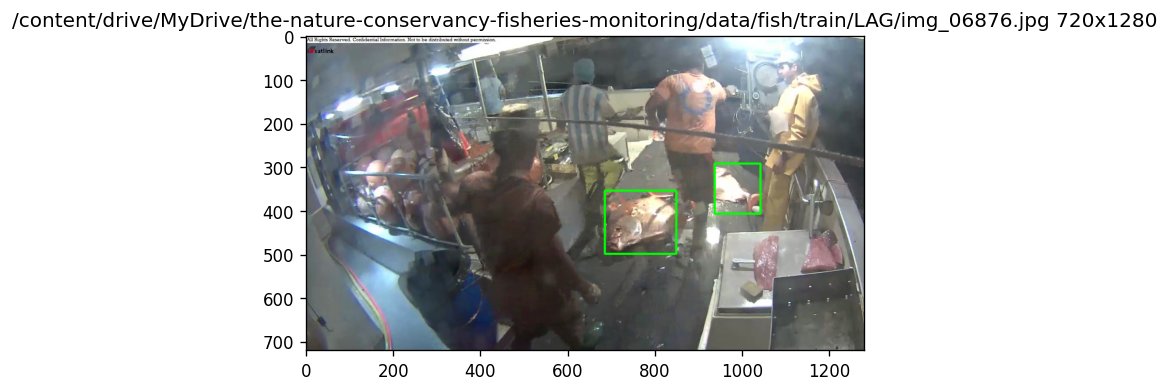

In [36]:
from matplotlib import pyplot as plt


annotation = boxes['lag'][10]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

### Распределение размеров разметки

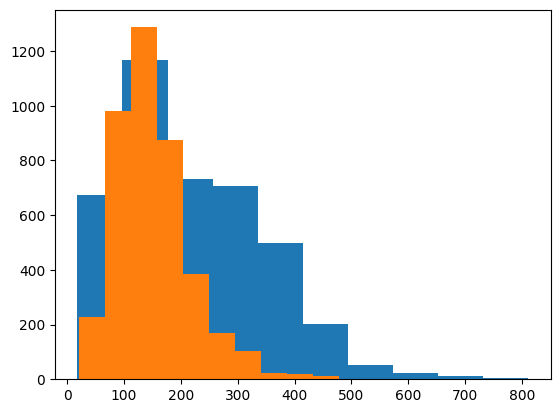

In [37]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [50]:
from tensorflow.keras.applications import vgg16

IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False

feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

(None, 23, 37, 512)


In [51]:
print(f'Итого имеем сетку из якорей размерностью {feature_tensor.shape[1]} x {feature_tensor.shape[2]}')

Итого имеем сетку из якорей размерностью 23 x 37


# Сетка якорей (anchor grid)

In [52]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150.

# сетка якорей, размер определяется соотношением
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

ANCHOR_CENTERS.shape, IMG_HEIGHT, FEATURE_SHAPE

((2, 23, 37), 750, (23, 37))

In [53]:
CLASSES = list(boxes.keys())                ## все возможные классы
CLASS_FEATURES = len(CLASSES)               ## кол-во классов
FRAME_FEATURES = 5                          ## кол-во признаков рамки
TOTAL_FEATURES = FRAME_FEATURES + CLASS_FEATURES  ## общее кол-во признаков

def ohe_encode(label):             ## энкодер
  res = np.zeros(len(CLASSES))
  res[CLASSES.index(label)] = 1.
  return res

def ohe_decode_proba(lst):         ## декодер
  return CLASSES[np.argmax(lst)]

In [54]:
# метрика близости рамок
# метрика близости рамок
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):

    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale

    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale

    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2

    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))

    intersection = dx * dy if (dx > 0 and dy > 0) else 0.

    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection

    return intersection / union

# упаковка: формирование тензора признаков
def encode_anchors(annotation, img_shape, class_features, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0], FEATURE_SHAPE[1], FRAME_FEATURES), dtype=np.float32) ## создаем пустой тензор признаков 23x37xFRAME_FEATURES
    x_scale = 1. * IMG_WIDTH / img_shape[1]     # рассчитываем массштабирование по отношению к исходной картинке,
    y_scale = 1. * IMG_HEIGHT / img_shape[0]    # т.к. якорная сетка рассчитана под размеры исходной картинки
    for rect in annotation['annotations']:      # идем по каждой размеченной рамке и рассчитываем
        scores = []                             # как близко она к каждой нашей якорной рамке
        for row in range(FEATURE_SHAPE[0]):     # 23
            for col in range(FEATURE_SHAPE[1]): # 37
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))

        scores = sorted(scores, reverse=True)   # сортируем по убыванию соответствия (iou)
        if scores[0][0] < iou_thr:              # если лучшее значение хуже нашего критерия отбора iou_thr,
            scores = [scores[0]]                # то ничего не остается, как выбрать его
        else:                                   # но если такое значение есть или их даже несколько - берем их
            scores = [e for e in scores if e[0] > iou_thr]

        # для каждого из отобранных значений считаем поправки (производные) по параметрам
        # и заносим их в тензор признаков
        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = [1., dx, dy, dw, dh]

    return encoded, class_features ## добавляем фичи классов

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1): ## предсказание для классов
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):                   # делаем обход тензора признаков
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh = prediction[0][row, col]
            conf = _sigmoid(logit)
            if conf > conf_thr:                           # если значение сигмоиды больше порога
                anchor_x = ANCHOR_CENTERS[1, row, col]    # получаем координаты якоря
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH, # восстанавливаем рамку
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf})
    return rectangles, prediction[1]     ## сохраняем значения признаков классификации

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles

    boxes = [[r['y'],         # превращаем из x1,y1,w,h в x1,y1,x2,y2
              r['x'],         # перед применением встроенного non_max_suppression
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)

    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

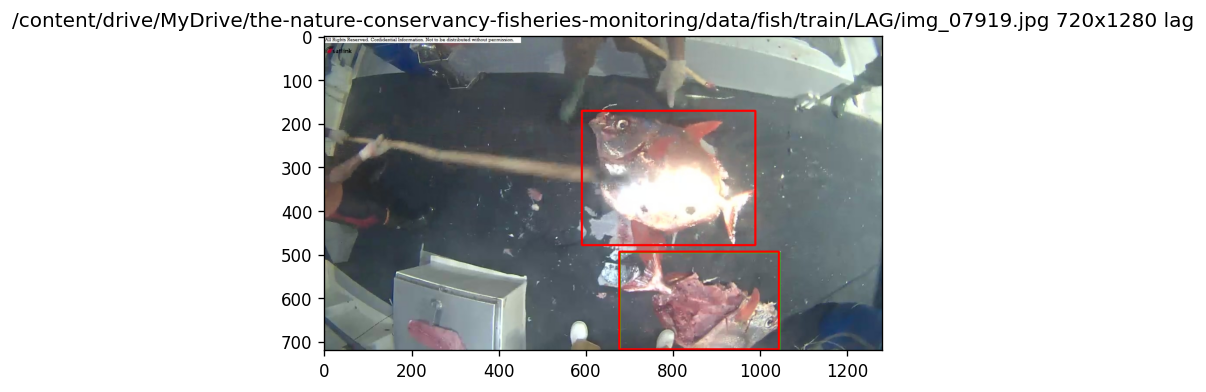

In [55]:
annotation = boxes['lag'][0]
class_features = ohe_encode(annotation['cl'])  ## кодируем класс в OHE

encoded = encode_anchors(annotation, (IMG_HEIGHT, IMG_WIDTH), class_features, iou_thr=0.5)

decoded, decoded_cl = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf']) # сортируем по убыванию conf

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{} {}'.format(
    annotation['filename'], img.shape[0], img.shape[1], ohe_decode_proba(decoded_cl)));

In [56]:
print("до обработки:")          ## выводим все фичи до и после обработки
for ann in annotation["annotations"]:
  if ann['class'] == "rect":
    print(f"x: {ann['x']}, \ty: {ann['y']}, \tw: {ann['width']}, \th: {ann['height']}, \tcs: {annotation['cl']}")
print("после:")
for da in decoded:
  print(f"x: {da['x']}, \ty: {da['y']}, \tw: {da['width']}, \th: {da['height']}, \tcs: {ohe_decode_proba(decoded_cl)}, \tclass: {decoded_cl}")

до обработки:
x: 790.0000000000019, 	y: 325.0000000000008, 	w: 398.0000000000009, 	h: 308.0000000000008, 	cs: lag
x: 861.000000000002, 	y: 607.0000000000015, 	w: 366.0000000000008, 	h: 224.0000000000005, 	cs: lag
после:
x: 790.0000004123998, 	y: 325.0, 	w: 398.0, 	h: 308.0, 	cs: lag, 	class: [0. 0. 0. 1. 0. 0.]
x: 860.9999971132022, 	y: 606.9999992536463, 	w: 366.0, 	h: 224.0, 	cs: lag, 	class: [0. 0. 0. 1. 0. 0.]


## Функция потерь

In [57]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0],
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]

    # TODO: добавьте функцию потерь для классификации детекции

    y_true = K.reshape(y_true, (batch_size, -1, FRAME_FEATURES)) ##
    y_pred = K.reshape(y_pred, (batch_size, -1, FRAME_FEATURES)) ##

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)

    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)

    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)

    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])

    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)

    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)

    return total_conf_loss + 0.5 * loc_loss

## Загрузка данных

In [59]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y, y_cl = [], [], [] ##
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                class_features = ohe_encode(boxes[j]['cl']) ## представляем класс в OHE
                encode, encode_cl = encode_anchors(boxes[j], img_shape, class_features) ##
                y.append(encode)
                y_cl.append(encode_cl) ## отдельно формируем данные для 2-ого выхода
                X.append(img)
            yield np.array(X), [np.array(y), np.array(y_cl)] ## отдаем вход и оба выхода

## Добавляем выход детектора

In [60]:
"""
# удалим сужествующую модель
# если она еать в памяти
try:
  del model
except:
  pass

output = L.BatchNormalization()(feature_tensor)

model_vgg16 = L.Conv2D(FRAME_FEATURES,   # 5
                       kernel_size=(1, 1),
                       activation='relu',
                       kernel_regularizer='l2',
                       name='detector')(output)

# TODO: добавьте выходы для классификации детекции
# попробую нарисовать свой класситфикатор
# архитектура Inception мне очень нравится)
# layer_1
layer_1_1 = L.Conv2D(10, (1,1), padding='same', activation='relu')(output)
layer_1_1 = L.Conv2D(10, (3,3), padding='same', activation='relu')(layer_1_1)

layer_1_2 = L.Conv2D(10, (1,1), padding='same', activation='relu')(output)
layer_1_2 = L.Conv2D(10, (5,5), padding='same', activation='relu')(layer_1_2)

layer_1_3 = L.MaxPooling2D((3,3), strides=(1,1), padding='same')(output)
layer_1_3 = L.Conv2D(10, (1,1), padding='same', activation='relu')(layer_1_3)

merged_1 = L.concatenate([layer_1_1, layer_1_2, layer_1_3], axis = 3)
merged_1 = L.MaxPooling2D((4,4), strides=(2,2), padding='same')(merged_1)

# layer_2
layer_2_1 = L.Conv2D(10, (1,1), padding='same', activation='relu')(merged_1)
layer_2_1 = L.Conv2D(10, (3,3), padding='same', activation='relu')(layer_2_1)

layer_2_2 = L.Conv2D(10, (1,1), padding='same', activation='relu')(merged_1)
layer_2_2 = L.Conv2D(10, (5,5), padding='same', activation='relu')(layer_2_2)

layer_2_3 = L.MaxPooling2D((3,3), strides=(1,1), padding='same')(merged_1)
layer_2_3 = L.Conv2D(10, (1,1), padding='same', activation='relu')(layer_2_3)

merged_2 = L.concatenate([layer_2_1, layer_2_2, layer_2_3], axis = 3)
merged_2 = L.MaxPooling2D((3,3), strides=(2,2), padding='same')(merged_2)

# layer_3
layer_3_1 = L.Conv2D(10, (1,1), padding='same', activation='relu')(merged_2)
layer_3_1 = L.Conv2D(10, (3,3), padding='same', activation='relu')(layer_3_1)

layer_3_2 = L.Conv2D(10, (1,1), padding='same', activation='relu')(merged_2)
layer_3_2 = L.Conv2D(10, (5,5), padding='same', activation='relu')(layer_3_2)

layer_3_3 = L.MaxPooling2D((3,3), strides=(1,1), padding='same')(merged_2)
layer_3_3 = L.Conv2D(10, (1,1), padding='same', activation='relu')(layer_3_3)

merged_3 = L.concatenate([layer_3_1, layer_3_2, layer_3_3], axis = 3)
merged_3 = L.MaxPooling2D((2,2), strides=(1,1), padding='same')(merged_3)
merged = L.Flatten()(merged_3)

# объединим
model_vgg16 = L.Flatten()(model_vgg16)
model_inception = merged
concatenated_layer = L.concatenate([model_vgg16, model_inception])

# добавим полносвязные слои
out = L.Dense(64, activation='relu')(concatenated_layer)
out = L.BatchNormalization()(out)
out = L.Dense(64, activation='relu')(out)
#out = L.BatchNormalization()(out)
#out = L.Dense(32, activation='relu')(out)
out = L.Dense(1, activation='sigmoid')(out)

model = tf.keras.Model(inputs=features.inputs,
                       outputs=output,
                       name='the-nature-conservancy-fisheries-monitoring')
model.summary()
"""

"\n# удалим сужествующую модель\n# если она еать в памяти\ntry:\n  del model\nexcept:\n  pass\n\noutput = L.BatchNormalization()(feature_tensor)\n\nmodel_vgg16 = L.Conv2D(FRAME_FEATURES,   # 5\n                       kernel_size=(1, 1), \n                       activation='relu',\n                       kernel_regularizer='l2', \n                       name='detector')(output)\n\n# TODO: добавьте выходы для классификации детекции\n# попробую нарисовать свой класситфикатор\n# архитектура Inception мне очень нравится)\n# layer_1\nlayer_1_1 = L.Conv2D(10, (1,1), padding='same', activation='relu')(output)\nlayer_1_1 = L.Conv2D(10, (3,3), padding='same', activation='relu')(layer_1_1)\n\nlayer_1_2 = L.Conv2D(10, (1,1), padding='same', activation='relu')(output)\nlayer_1_2 = L.Conv2D(10, (5,5), padding='same', activation='relu')(layer_1_2)\n\nlayer_1_3 = L.MaxPooling2D((3,3), strides=(1,1), padding='same')(output)\nlayer_1_3 = L.Conv2D(10, (1,1), padding='same', activation='relu')(layer_1_3)\

In [65]:
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers as L

In [66]:
output = L.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции

o1 = L.Conv2D(FRAME_FEATURES, ## выход детектора
                                kernel_size=(1, 1),
                                activation='linear',
                                kernel_regularizer='l2', name='detector')(output)
o2 = L.Flatten()(output)
o2 = L.Dense(CLASS_FEATURES, activation='softmax', name='classifier')(o2) ## выход классификатора
output = [o1, o2]

model = keras.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 750, 1200, │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 750, 1200, │      1,792 │ input_layer_2[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 750, 1200, │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 375, 600,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 375, 600,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 375, 600,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 187, 300,  │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 187, 300,  │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 187, 300,  │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 187, 300,  │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 93, 150,   │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 93, 150,   │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 93, 150,   │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 93, 150,   │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 46, 75,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 46, 75,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 46, 75,    │  2,359,808 │ block5_conv1[0][

 Total params: 17,333,579 (66.12 MB)

 Trainable params: 9,697,291 (36.99 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

## Обучение

In [67]:
adam = keras.optimizers.Adam()
model.compile(optimizer=adam,
              loss=[total_loss, 'categorical_crossentropy']) ## добавляем отдельный loss для классификатора

In [68]:
batch_size = 16

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

model.fit(gen,
          steps_per_epoch=steps_per_epoch,
          epochs=1, ##
          #callbacks=[checkpoint]
          )

TypeError: `output_signature` must contain objects that are subclass of `tf.TypeSpec` but found <class 'list'> which is not.

In [ ]:
from tensorflow import keras

adam = keras.optimizers.Adam()
model.compile(optimizer=adam,
              loss=total_loss,
              metrics=[confidence_loss])

In [ ]:
from keras import callbacks

batch_size = 5

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) // batch_size
print(steps_per_epoch)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector.keras',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq=10)

model.fit(gen,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          #callbacks=[checkpoint]
          )

## Результат работы детектора

In [ ]:
# model.load_weights('data/fish/fishdetector_weights.hdf5')

In [ ]:
annotation = boxes['lag'][0]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.2)
decoded = non_max_suppression(decoded,
                              max_output_size=5,
                              iou_threshold=0.1)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));

## Визуализируем предсказание на тесте

In [ ]:
# скопиркем путь
# /content/drive/MyDrive/the-nature-conservancy-fisheries-monitoring/data/fish/test_stg1

In [ ]:
test_images = glob('/content/drive/MyDrive/the-nature-conservancy-fisheries-monitoring/data/fish/test_stg1/*.jpg')[:5]


plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.0)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)

    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename));

## Агрегация результатов

In [ ]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0